<a href="https://colab.research.google.com/github/sukilsiva/Machine-Learnig-Deep-Learning-Code/blob/master/Audio_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
!git clone https://github.com/karolpiczak/ESC-50.git

fatal: destination path 'ESC-50' already exists and is not an empty directory.


In [0]:
import tensorflow
from tensorflow import keras 
from keras.models import Sequential
from keras.layers import Dropout,Dense,Conv2D,MaxPooling2D,Flatten
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
import librosa
import librosa.display
import random

In [42]:
data = pd.read_csv("/content/ESC-50/meta/esc50.csv")
data.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [43]:
data.shape

(2000, 7)

In [44]:
# to check how many unique voices the dataset

len(data.category.unique())

50

In [45]:
data = data[['filename', 'fold', 'category']]
data.head()

,filename,fold,category
0,1-100032-A-0.wav,1,dog
1,1-100038-A-14.wav,1,chirping_birds
2,1-100210-A-36.wav,1,vacuum_cleaner
3,1-100210-B-36.wav,1,vacuum_cleaner
4,1-101296-A-19.wav,1,thunderstorm


In [46]:
# lets check the librosa working with single audio

y, sr = librosa.load("/content/ESC-50/audio/1-100032-A-0.wav", duration=3)
ps = librosa.feature.melspectrogram(y=y, sr=sr)
ps.shape

(128, 130)

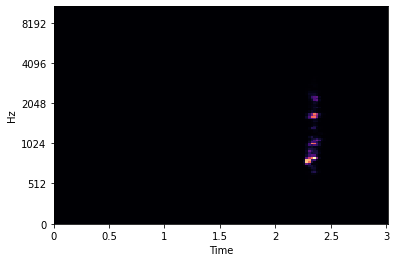

In [47]:
librosa.display.specshow(ps, y_axis='mel', x_axis='time')

As the librosa is time consuming process we use only the sample of 100 datas for quick process 

In [48]:
data = data.sample(frac=0.05, random_state=42)
data.shape

(100, 3)

In [49]:
data.head(2)

,filename,fold,category
1860,5-221950-A-22.wav,5,clapping
353,1-79220-A-17.wav,1,pouring_water


In [50]:
data.category.nunique()

45

In [0]:
D = []

for row in data.itertuples():
  y, sr = librosa.load('/content/ESC-50/audio/'+row.filename, duration=2.97)
  ps = librosa.feature.melspectrogram(y = y, sr= sr)
  if ps.shape != (128,128): continue
  D.append( (ps, row.category) )

In [0]:
dataset = D
random.shuffle(dataset)

In [0]:
train = dataset[:75]
test = dataset[75:]

x_train, y_train = zip(*train)
x_test, y_test = zip(*test)

In [0]:
# reshaping the array before feeding it into an CNN
x_train = np.array([ x.reshape((128,128,1)) for x in x_train])
x_test = np.array([ x.reshape((128,128,1)) for x in x_test])

In [0]:
lb = LabelEncoder()
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)

y_train = np.array(to_categorical(y_train, 38))
y_test = np.array(to_categorical(y_test, 38))

In [0]:
# Building the convolutional neural network 
size = (128,128,1)

model = Sequential()
model.add(Conv2D (24, (5,5), input_shape = size, strides=(1,1), activation = 'relu'))
model.add(MaxPooling2D ((4,2), strides=(4,2)))

model.add(Conv2D (48, (5,5), activation='relu'))
model.add(MaxPooling2D ((4,2), strides=(4,2)))

model.add(Conv2D(48, (5,5), activation='relu'))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense (64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense (38, activation='softmax'))

In [0]:
model.compile(optimizer = "Adam",
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [68]:
model.fit(x=x_train,
          y=y_train,
          epochs=15,
          batch_size=16,
          validation_data=(x_test,y_test))

Train on 75 samples, validate on 25 samples
Epoch 1/15
75/75 [==============================] - 2s 25ms/step - loss: 28.2937 - accuracy: 0.0667 - val_loss: 5.2779 - val_accuracy: 0.0800
Epoch 2/15
75/75 [==============================] - 1s 18ms/step - loss: 14.2869 - accuracy: 0.0133 - val_loss: 3.7094 - val_accuracy: 0.1200
Epoch 3/15
75/75 [==============================] - 1s 18ms/step - loss: 8.9082 - accuracy: 0.0400 - val_loss: 3.6498 - val_accuracy: 0.0800
Epoch 4/15
75/75 [==============================] - 1s 18ms/step - loss: 4.7985 - accuracy: 0.0400 - val_loss: 3.7450 - val_accuracy: 0.0800
Epoch 5/15
75/75 [==============================] - 1s 17ms/step - loss: 4.5582 - accuracy: 0.0800 - val_loss: 3.7416 - val_accuracy: 0.0800
Epoch 6/15
75/75 [==============================] - 1s 18ms/step - loss: 4.6963 - accuracy: 0.1067 - val_loss: 3.6875 - val_accuracy: 0.1200
Epoch 7/15
75/75 [==============================] - 1s 18ms/step - loss: 3.8135 - accuracy: 0.0800 - val_los

In [69]:
score = model.evaluate(x=x_test,
                       y=y_test)

print("test score : {}".format(score[0]))
print("test accuracy : {}".format(score[1]))

25/25 [==============================] - 0s 5ms/step
test score : 4.0801100730896
test accuracy : 0.07999999821186066


## **DATA AUGUMENTATION**

In [0]:
### Varying time 

y, sr = librosa.load('/content/ESC-50/audio/1-100032-A-0.wav', duration = 2.97)
y_changed = librosa.effects.time_stretch(y, rate = 0.87)
librosa.output.write_wav('/content/ESC-50/changed_time_stretch/1-100032-A-0.wav', y_changed, sr)

In [0]:
### varying pitch

## by doing the data augumentation actually we can improve the accuracy

In [74]:
input_data = input("Enter the data to tested:")

Enter the data to tested:/content/ESC-50/changed_time_stretch/1-100032-A-0.wav


In [0]:
test_data = []
y, sr = librosa.load(input_data, duration=2.97)
ps = librosa.feature.melspectrogram(y = y, sr = sr)
test_data.append(ps)

In [0]:
test_array = np.array([x.reshape ((128,128,1)) for x in test_data])

In [0]:
result = model.predict(test_array)

In [0]:
result = np.argmax(result, axis=1)

In [95]:
result

array([26])